In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
#Creating inspector and viewing data structure
inspector = inspect(engine)
tables = inspector.get_table_names()

In [10]:
for t in tables:
    print(f'Table Name: {t}')
    print()
    columns = inspector.get_columns(t)
    for c in columns:
        print(c['name'], c["type"])
    print()

Table Name: measurement

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Table Name: station

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.


('2017-08-23',)

In [11]:
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23',)

In [12]:
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

from datetime import datetime
latest = datetime.strptime(latest_date[0], '%Y-%m-%d')
dt_year_ago = latest - dt.timedelta(days=365)
year_ago = datetime.date(dt_year_ago)
str(year_ago)

'2016-08-23'

In [13]:
# Perform a query to retrieve the data and precipitation scores

query = f"SELECT date, prcp FROM Measurement WHERE date >= '{str(year_ago)}'"
query

"SELECT date, prcp FROM Measurement WHERE date >= '2016-08-23'"

In [14]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names - this is done when when generating the query string
prcp_df = pd.read_sql(query,engine)
prcp_df

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
2225,2017-08-19,0.09
2226,2017-08-20,NaN
2227,2017-08-21,0.56
2228,2017-08-22,0.50


In [15]:
#Dropping rows with null values
prcp_clean = prcp_df.dropna(axis = 0)
prcp_clean

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
2223,2017-08-17,0.13
2225,2017-08-19,0.09
2227,2017-08-21,0.56
2228,2017-08-22,0.50


In [16]:
#Making sure we have all dates between start and end date (inclusive)
dates = prcp_clean.nunique()
dates

date    366
prcp    160
dtype: int64

In [18]:
#Do we have multiple values for each date? Yes, we have at least two measurements per date for the last year.
prcp_clean['date'].value_counts()

2017-02-24    7
2017-06-30    7
2016-09-20    7
2016-12-21    7
2016-09-22    7
             ..
2017-08-18    3
2017-08-13    3
2017-08-12    3
2017-08-05    2
2017-08-20    2
Name: date, Length: 366, dtype: int64

In [20]:
# Sort the dataframe by date
prcp_sorted = prcp_clean.sort_values(by=['date'])
prcp_sorted

,date,prcp
0,2016-08-23,0.00
1192,2016-08-23,0.02
704,2016-08-23,0.05
1881,2016-08-23,0.70
361,2016-08-23,0.15
...,...,...
2228,2017-08-22,0.50
360,2017-08-23,0.00
1528,2017-08-23,0.08
1008,2017-08-23,0.00


In [21]:
#Getting the max value for each date (to match the barplot) and resetting the index
prcp = prcp_sorted.groupby('date')['prcp'].max()
prcp_agg = pd.DataFrame(prcp)
prcp_agg.reset_index(level=0, inplace=True)
prcp_agg

,date,prcp
0,2016-08-23,1.79
1,2016-08-24,2.28
2,2016-08-25,0.21
3,2016-08-26,0.04
4,2016-08-27,0.18
...,...,...
361,2017-08-19,0.09
362,2017-08-20,0.01
363,2017-08-21,0.56
364,2017-08-22,0.50


In [23]:
##Creating evenly spaced tick labels
def create_ticks(length,num):
    ticks = []
    n_ticks = range(0,num)
    inc = round(length/num)
    for n in n_ticks:
        ticks.append(n*inc)
        
    return ticks

In [24]:
xticks = create_ticks(366,5)
xticks

[0, 73, 146, 219, 292]

([<matplotlib.axis.XTick at 0x1c94b002bf0>,
 [Text(0, 0, '2016-08-23'),
  Text(73, 0, '2016-11-04'),
  Text(146, 0, '2017-01-16'),
  Text(219, 0, '2017-03-30'),
  Text(292, 0, '2017-06-11')])

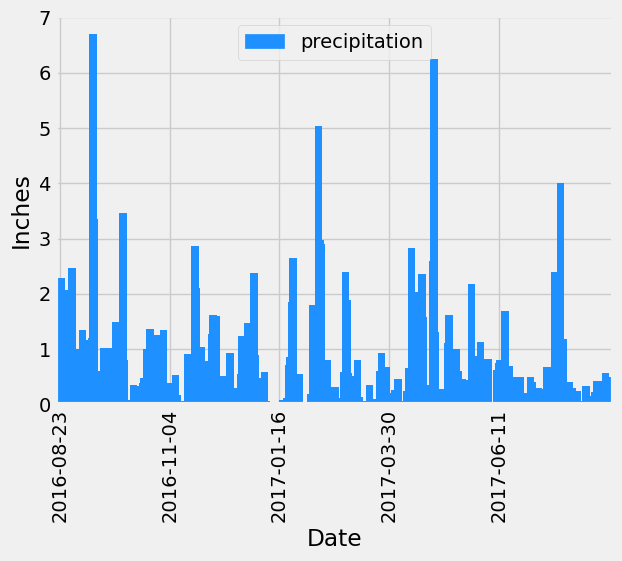

In [29]:
# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.patches as mpatches
prcp_agg.plot.bar(x='date',y='prcp', width = 5, color = 'dodgerblue')
plt.xlabel('Date')
plt.ylabel('Inches')
blue_patch = mpatches.Patch(color='dodgerblue', label='precipitation')
plt.legend(handles=[blue_patch],loc='upper center')
plt.grid(visible=True, which='major',axis='both')
plt.xticks(xticks,rotation=90)

Text(0, 0.5, 'Inches')

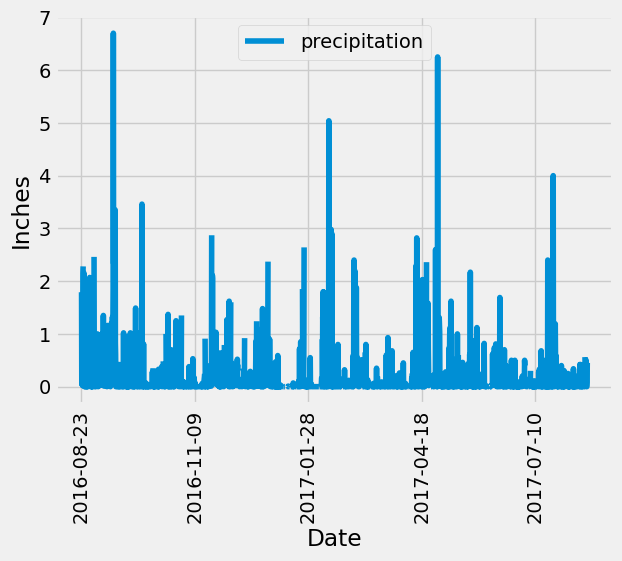

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.


# Perform a query to retrieve the data and precipitation scores


# Save the query results as a Pandas DataFrame. Explicitly set the column names


# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [31]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_sorted.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset


[(9,)]

In [32]:
session.query(func.count(distinct(Measurement.station))).all()

[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [33]:
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [34]:
active = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
active[0]

'USC00519281'

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


[(54.0, 85.0, 71.66378066378067)]

In [35]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), \
              func.avg(Measurement.tobs)).filter(Measurement.station == active[0]).all()

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 4.183333333333314, 'Temperature')

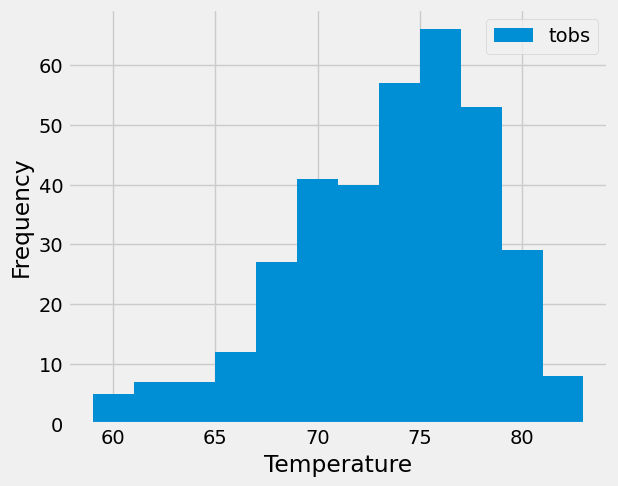

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


In [36]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = f"SELECT date, station, tobs FROM Measurement WHERE date >= '{str(year_ago)}' AND station == '{active[0]}'"
query

"SELECT date, station, tobs FROM Measurement WHERE date >= '2016-08-23' AND station == 'USC00519281'"

In [37]:
temp_df = pd.read_sql(query,engine)
temp_df

,date,station,tobs
0,2016-08-23,USC00519281,77.0
1,2016-08-24,USC00519281,77.0
2,2016-08-25,USC00519281,80.0
3,2016-08-26,USC00519281,80.0
4,2016-08-27,USC00519281,75.0
...,...,...,...
347,2017-08-14,USC00519281,77.0
348,2017-08-15,USC00519281,77.0
349,2017-08-16,USC00519281,76.0
350,2017-08-17,USC00519281,76.0


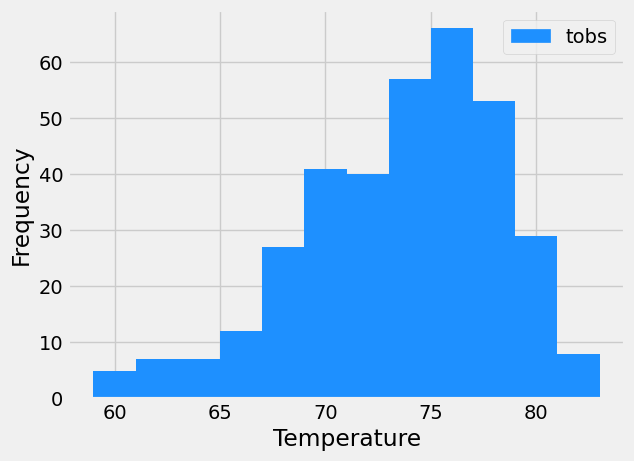

In [44]:
temp_df.hist(column='tobs',bins=12,alpha=1,color='dodgerblue')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('')
blue_patch = mpatches.Patch(color='dodgerblue', label='tobs')
plt.legend(handles=[blue_patch])

# Close Session

In [45]:
# Close Session
session.close()